In [1]:
# import packages needed for entire model

import tensorflow as tf
from keras import layers, regularizers, metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import softsign
import shutil
import random
import sys
import h5py
from google.colab import drive
terminal = sys.stdout
# mount to google drive in order to pull data file
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Option 1 for running Network
# Takes Random Data of a specified size
subsetSize= 15000
validationSize = 2000
splicingVal = 11
numOutputs = int(220/splicingVal)

# import data file, splice data, split into testing and training data
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'][()])
z = list(zip(imgs, spectra, atfrac))
badIndices = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or round(np.sum(atfrac[i])) == 0]
badIndices.reverse()
for index in badIndices:
  del z[index]
random.shuffle(z)
imgs, spectra, atfrac = zip(*z)
imgs, spectra, atfrac  = np.array(imgs), np.array(spectra), np.array(atfrac)
spectra = np.array([x[::splicingVal] for x in spectra])
atfracNN = np.array(list(atfrac[0:subsetSize]))
imgsNN = np.array(list(imgs[0:subsetSize]))
spectraNN = np.array(list(spectra[0:subsetSize]))
atfrac_valid = np.array(list(atfrac[subsetSize:subsetSize+validationSize]))
x_valid = np.array(list(imgs[subsetSize:subsetSize+validationSize]))
y_valid = np.array(list(spectra[subsetSize:subsetSize+validationSize]))
del imgs, spectra, atfrac, z
#x_train, x_test, y_train, y_test = train_test_split(imgsNN, spectraNN, test_size = 0.2, random_state = None)

In [2]:
# Option 2 for running Network
# Takes a specified minimum amount of each element up to 1077

minAmount = 1000 #Max is 1077
validationSize = 2000
splicingVal = 11

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

# mount to google drive in order to pull data file
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'][()])
atfrac_keys = hf['atfrac_keys']
# import data file, splice data, split into testing and training data
z = list(zip(imgs, spectra, atfrac))
badIndices = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or round(np.sum(atfrac[i])) == 0]
badIndices.reverse()
for index in badIndices:
  del z[index]
random.shuffle(z)
imgs, spectra, atfrac = zip(*z)
imgs, spectra, atfrac  = np.array(imgs), np.array(spectra), np.array(atfrac)
spectra = [x[::splicingVal] for x in spectra]
numOutputs = int(220/splicingVal)
nonZeroList = [nonZeroInList(each) for each in atfrac]
oxideTracker = {}
indexListNN = []
indexList_valid = []
for i in range(len(atfrac)):
  oxideTracker[str(i)] = 0
for i, oxide in enumerate(nonZeroList):
  used = False
  for info in oxide:
    metal = info[1]
    if oxideTracker[str(metal)] < minAmount:
      used = True
  if used:
    for info in oxide:
      metal = info[1]
      oxideTracker[str(metal)] += 1
    indexListNN.append(i)
  else:
    if len(indexList_valid) < validationSize:
      indexList_valid.append(i)
atfracNN, imgsNN, spectraNN, atfrac_valid, imgs_valid, spectra_valid = [], [], [], [], [], []
for index in indexListNN:
  atfracNN.append(atfrac[index])
  imgsNN.append(imgs[index])
  spectraNN.append(spectra[index])
for index in indexList_valid:
  atfrac_valid.append(atfrac[index])
  imgs_valid.append(imgs[index])
  spectra_valid.append(spectra[index])
atfracNN, imgsNN, spectraNN, atfrac_valid, imgs_valid = np.array(atfracNN), np.array(imgsNN), np.array(spectraNN), np.array(atfrac_valid), np.array(imgs_valid)
del imgs, spectra, atfrac, z, indexListNN, indexList_valid

In [ ]:
#Do not run. It's an experiment I have - Max
#x_train, x_test, y_train, y_test = train_test_split(imgs, spectra, test_size = 0.2, stratify = spectra)

array([2, 3])

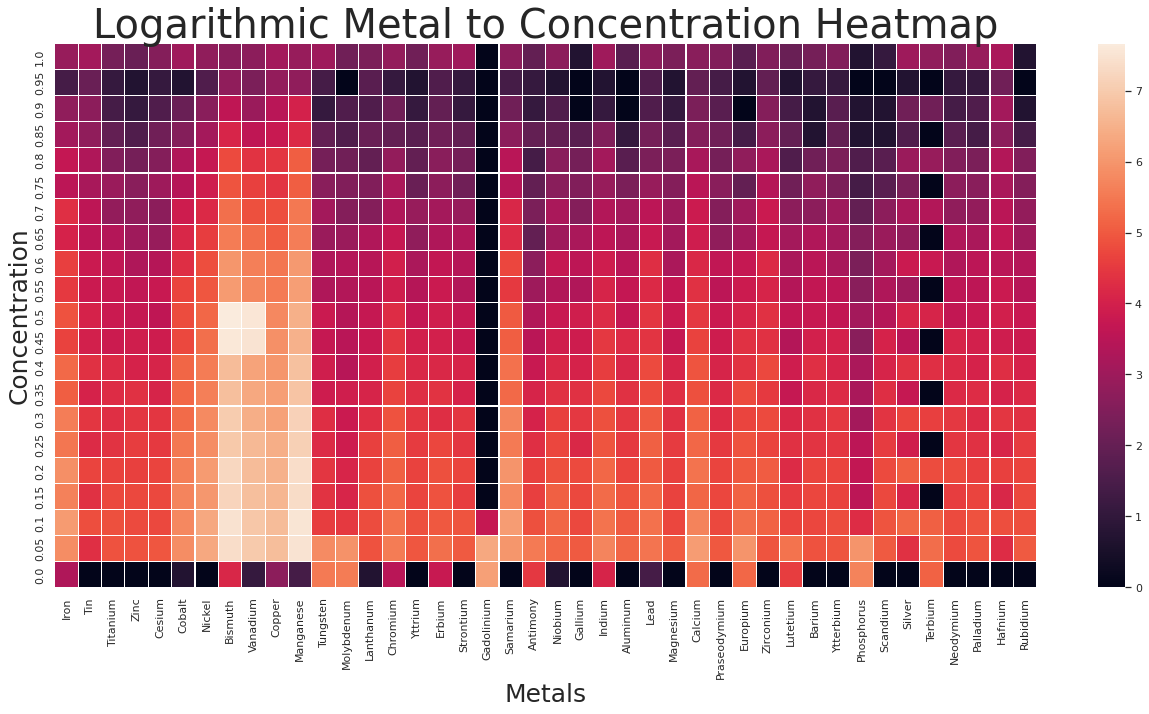

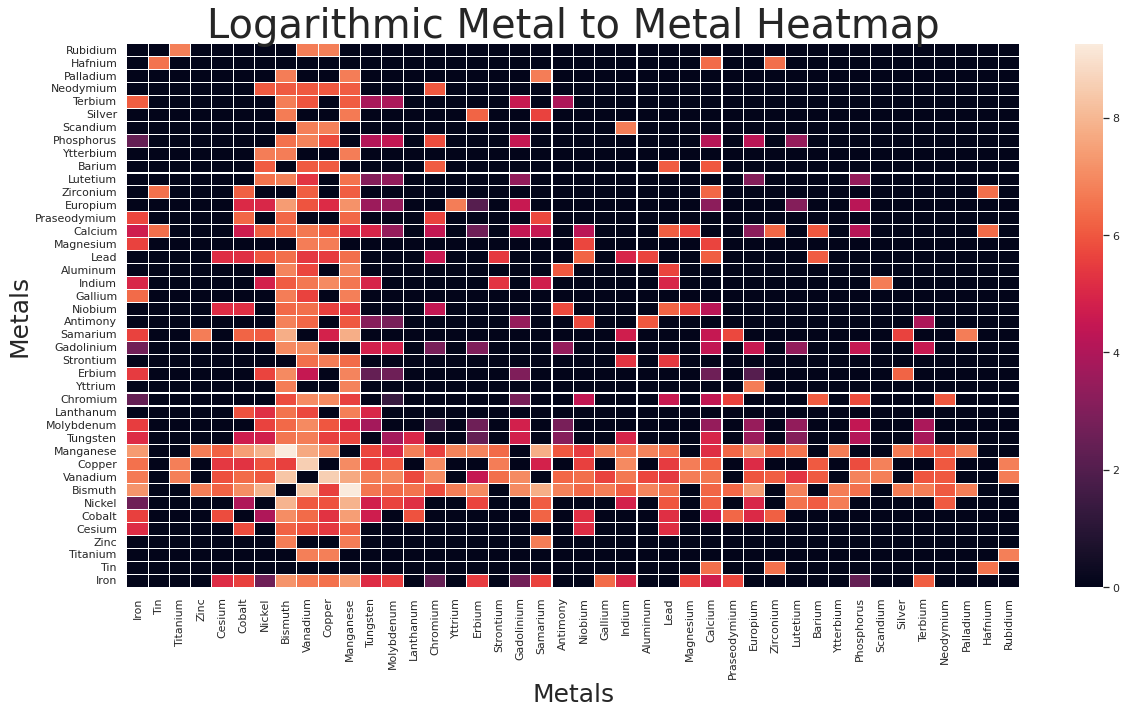

In [6]:
from tabulate import tabulate
import seaborn as sns

def myround(x, base=.05):
    return round(base * round(x/base), 2)

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

nonZeroList = [nonZeroInList(each) for each in atfracNN]
oxideToConc = {}
for i in range(len(hf['atfrac_keys'])):
  oxideToConc[str(i)] = {}
  for j in [round(x * 0.05, 2) for x in range(21)]:
    oxideToConc[str(i)][str(j)] = 1
for nonZero in nonZeroList:
  for info in nonZero:
    currMetal = info[1]
    conc = myround(info[2])
    try:
      oxideToConc[str(currMetal)][str(conc)] += 1
    except:
      print(info)
table = []
heatmap = []
oxides = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
oxides = oxides.split(', ') 
for i, each in enumerate(oxideToConc.values()):
  layer = [oxides[i]] + list(each.values())
  table.append(layer)
  heatmap.append(list(each.values()))
#print(tabulate(table, headers = ['Concentration'] + [round(x * 0.05, 2) for x in range(21)]))
sns.set(rc = {'figure.figsize':(22, 10)})
ax = sns.heatmap(np.log(np.transpose(heatmap)), xticklabels=oxides, yticklabels=[round(x * 0.05, 2) for x in range(21)], linewidths=.1) #, annot = True, fmt = 'd')
ax.invert_yaxis()
plt.title('Logarithmic Metal to Concentration Heatmap', fontdict={'fontsize': 40})
plt.xlabel('Metals', fontdict={'fontsize': 25})
plt.ylabel('Concentration', fontdict={'fontsize': 25})
plt.show()

oxideToOxide = {}
for i in range(len(hf['atfrac_keys'])):
  oxideToOxide[str(i)] = {}
  for j in range(len(hf['atfrac_keys'])):
    oxideToOxide[str(i)][str(j)] = 1
for nonZero in nonZeroList:
  for info in nonZero:
    currMetal = info[1]
    for otherInfo in nonZero:
      otherMetal = otherInfo[1]
      if currMetal != otherMetal:
        oxideToOxide[str(currMetal)][str(otherMetal)] += 1
      #else:
      #  oxideToOxide[str(currMetal)][str(otherMetal)] -= 1
table = []
heatmap = []
oxides = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
oxides = oxides.split(', ') 
for i, each in enumerate(oxideToOxide.values()):
  layer = [oxides[i]] + list(each.values())
  table.append(layer)
  heatmap.append(list(each.values()))
#print(tabulate(table, headers = oxides))
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.heatmap(np.log(np.array(heatmap)), xticklabels=oxides, yticklabels=oxides, linewidths=.1)# annot = True #, fmt = 'f')
ax.invert_yaxis()
plt.title('Logarithmic Metal to Metal Heatmap', fontdict={'fontsize': 40})
plt.xlabel('Metals', fontdict={'fontsize': 25})
plt.ylabel('Metals', fontdict={'fontsize': 25})
plt.show()

0 2996
1 1041
2 1038
3 1000
4 1009
5 2656
6 4139
7 15804
8 11156
9 6828
10 14364
11 1303
12 1206
13 1000
14 1737
15 1000
16 1274
17 1000
18 1085
19 3260
20 1036
21 1264
22 1000
23 1826
24 1130
25 1763
26 1000
27 2483
28 1000
29 1820
30 1473
31 1000
32 1000
33 1000
34 1020
35 1000
36 1000
37 1000
38 1000
39 1000
40 1000
41 1000


<BarContainer object of 42 artists>

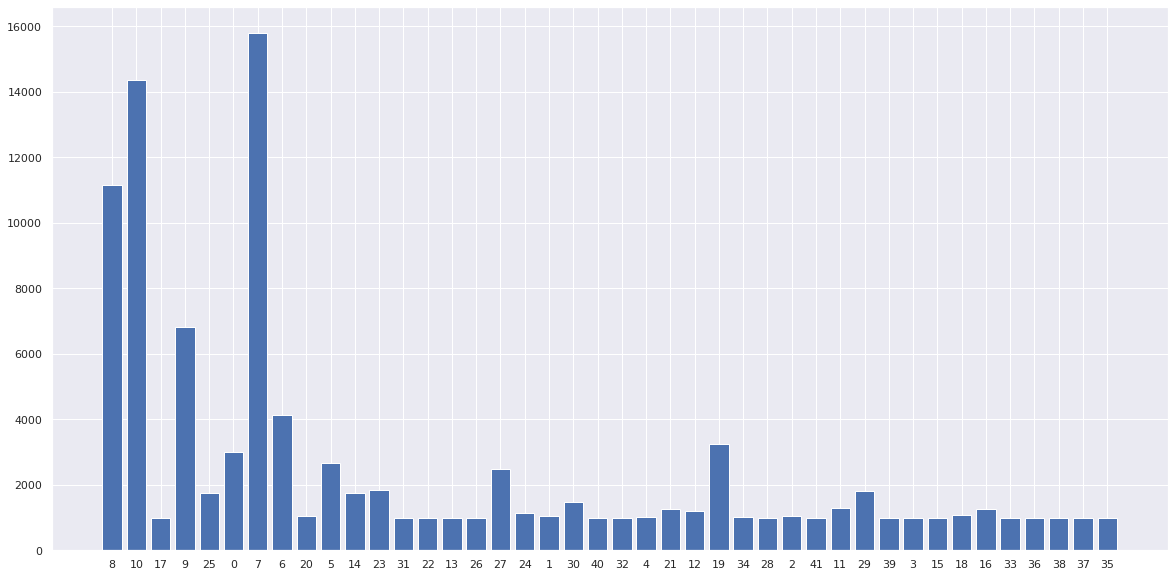

In [10]:
def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

nonZeroList = [nonZeroInList(each) for each in atfracNN]
dic = {}
for i in range(42):
  dic[str(i)] = 0
for nonZero in nonZeroList:
  for info in nonZero:
    metal = info[1]
    dic[str(metal)] += 1
for i in range(42):
  print(i, dic[str(i)])

plt.bar(dic.keys(), dic.values())

In [ ]:
# Current Neural Network Model function

def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = 'sigmoid')])
    model.summary()
    adamOpti = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(optimizer= adamOpti, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [ ]:
# Running Neural Network with averaging Ensemble, including tensorboard and early stopping

# Define number of networks, batches, and epochs 

numNetworks = 10
epochs = 50
batch_size = 32
log_folder = 'logs'

# Run Neural Network for the desired number of networks in the ensemble (numNetworks)


modelList = []
historyList= []

data = ShuffleSplit(n_splits=numNetworks, random_state=0, test_size=0.20, train_size=None)
data.get_n_splits(imgsNN, spectraNN)
for train_index, test_index in data.split(imgsNN, spectraNN):
  x_train, x_test = imgsNN[train_index], imgsNN[test_index]
  y_train, y_test = spectraNN[train_index], spectraNN[test_index]
  with open('EpochOutput.txt', 'a') as f:
    sys.stdout = f
    normal_model = get_conv_model_normal()
  sys.stdout = terminal
  normal_model.summary()
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1,
                callbacks= [early_stopping])
  modelList.append(normal_model)
  historyList.append(normal_history)


# Create predictions based on results of the neural network and ensemble 

def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]

# Create the geometric average of the output spectra from the predicted values from the ensemble

def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

# Create the arithmetic average of the output spectra from the predicted values from the ensemble, commented out for now for simplicity

# def ensemblePredictArithAverage(predictList, ele):
#  numNetworks = len(predictList)
#  prediction = 0
#  for predict in predictList:
#    prediction += predict[ele]
#  return prediction/numNetworks

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 dense_4 (Dense)             (None, 62, 62, 256)       16640     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 256)       0         
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_5 (Dense)             (None, 256)               62980352  
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
734/734 [==============================] - 44s 39ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 2/50
734/734 [==============================] - 28s 38ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 3/50
734/734 [==============================] - 28s 38ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 4/50
734/734 [==============================] - 28s 38ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 5/50
734/734 [==============================] - 28s 38ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/50
734/734 [==============================] - 28s 38ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/50
734/7

In [ ]:
# to get individual layer weights

#model = modelList[0]
#for layer in model.layers:
    #print(f'{layer.name}, {layer.weights}')

In [ ]:
# Get MSE Plot

from IPython.core.pylabtools import figsize
def closest_factor(num):
  n = int(np.ceil(np.sqrt(num)))
  if num % n == 0:
    return n, n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

low, high = closest_factor(numNetworks)
fig = plt.figure(1, figsize = (6*high,6*low))
plt.title('Mean Squared Error (MSE) Over Time', fontsize = 20)
for i in range(low):
  for j in range(high):
    index = high*i + j
    y = historyList[index].history
    plt.subplot(low, high, index+1)
    plt.plot(y['mean_squared_error'], color = 'b')
    plt.plot(y['val_mean_squared_error'], color = 'y')
    plt.legend(['MSE training data', 'MSE validation data'], prop={'size': 12})
    plt.title(f'Sequential Model {index+1}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
fig.suptitle('Mean Squared Error (MSE) Over Time', fontsize = 20)

plt.savefig('MSE_Plot.jpg')

Text(0.5, 1.0, 'Confidence Interval')

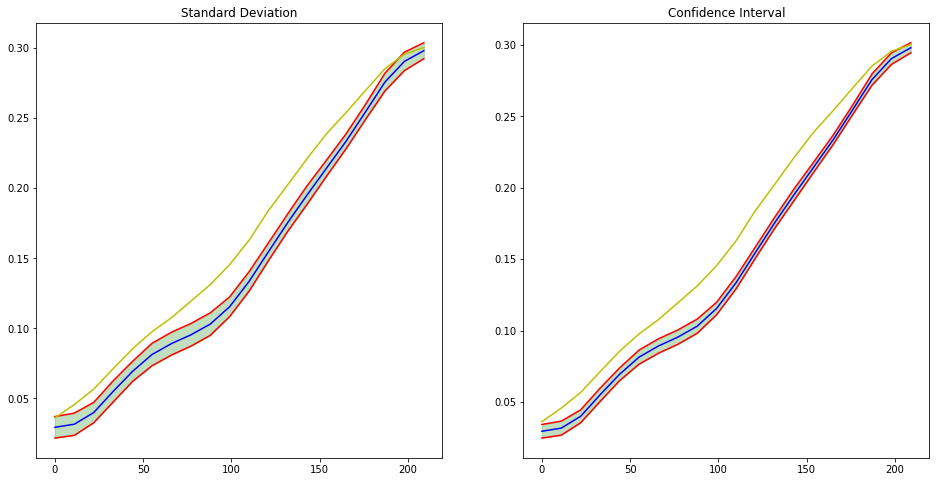

In [ ]:
# ONLY RUN IF NEEDED
# Show the confidence interval on the ensemble average prediction

def ensembleUncertainty(predictList, ele):
  newPredict = np.transpose(predictList, (1, 2, 0))
  return np.array([np.std(output) for output in newPredict[ele]])

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot lines
i = 0
topUQ = y[i]+UQ[i]
botUQ = y[i]-UQ[i]
ax[0].plot(x, topUQ, color="red")
ax[0].plot(x, botUQ, color="red")


# Fill area when income > expenses with green
ax[0].fill_between(
    x, topUQ, botUQ, where=(topUQ > botUQ), 
    interpolate=True, color="green", alpha=0.25, 
    label="Positive"
)
ax[0].plot(x, y_valid[i], color = 'y')
ax[0].plot(x, y[i], color="blue")
ax[0].set_title('Standard Deviation')

# Plot lines
i = 0
topUQ = y[i]+5*UQ[i]/np.sqrt(numNetworks)
botUQ = y[i]-5*UQ[i]/np.sqrt(numNetworks)
ax[1].plot(x, topUQ, color="red")
ax[1].plot(x, botUQ, color="red")


# Fill area when income > expenses with green
ax[1].fill_between(
    x, topUQ, botUQ, where=(topUQ > botUQ), 
    interpolate=True, color="green", alpha=0.25, 
    label="Positive"
)

ax[1].plot(x, y_valid[i], color = 'y')
ax[1].plot(x, y[i], color="blue")
ax[1].set_title('Confidence Interval')

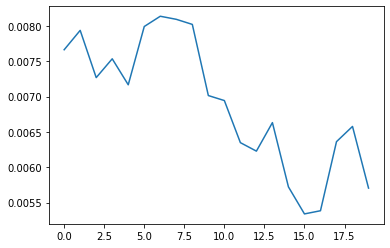

In [ ]:
# ONLY RUN IF NEEDED
# Shows graph of how standard deviation changes over the model

x = np.array([x for x in range(0,220,splicingVal)])
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
plt.plot(UQ[i])

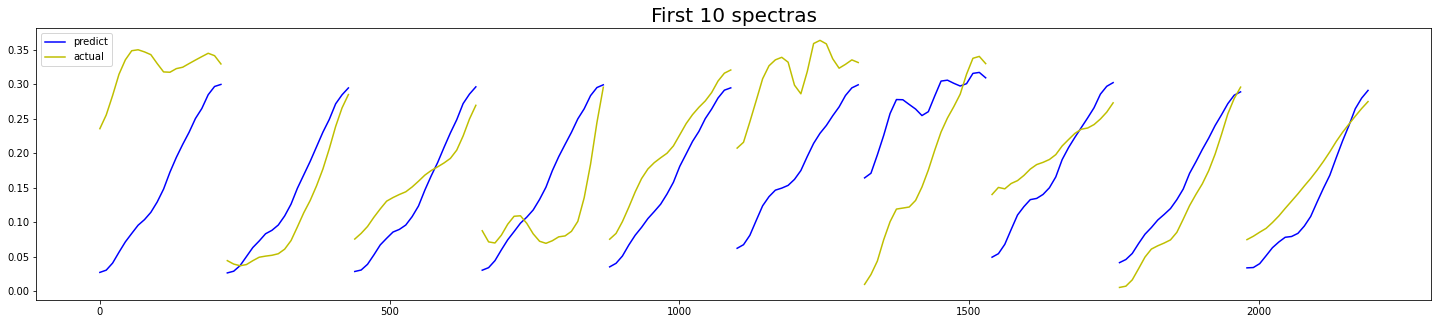

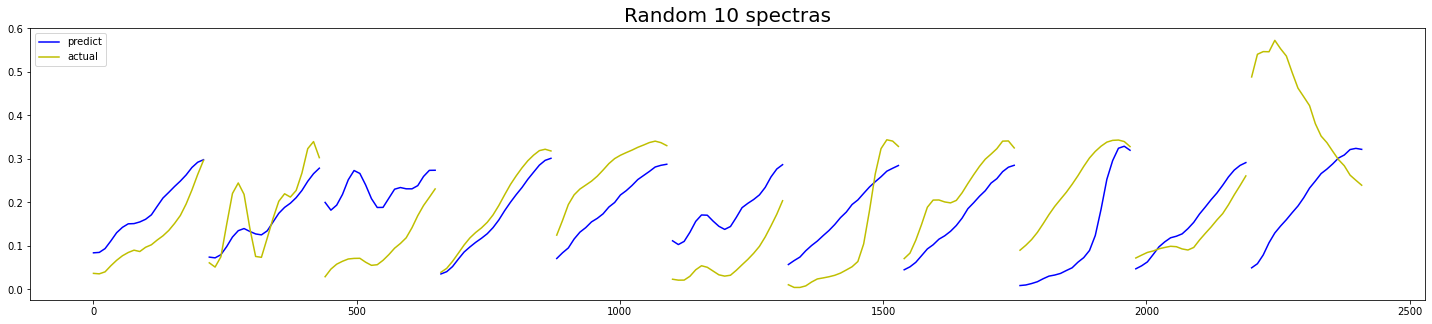

In [ ]:
# DO NOT RUN UNLESS NEEDED - not that important anymore and 100 random is better representation
# Plots first 10 spectra images on a single graph

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x + 220*i, y[i] , color = 'b')
  plt.plot(x + 220*i, y_test[i], color = 'y')
  plt.legend(['predict', 'actual'], loc='upper left')
plt.title('First 10 spectras', fontsize = 20)
plt.savefig('First10.jpg')
plt.show()

# Plots random 10 spectra images on a single graph

rando = [x for x in range(10, len(y))]
random.shuffle(rando)
i = 0
fig = plt.figure(figsize=(25, 5))
for rand in rando:
  if i > 10:
    break
  plt.plot(x + 220*i, y[rand], color = 'b')
  plt.plot(x + 220*i, y_test[rand], color = 'y')
  plt.legend(['predict', 'actual'], loc='upper left')
  i+=1
plt.title('Random 10 spectras', fontsize = 20)
plt.savefig('Random10.jpg')
plt.show()

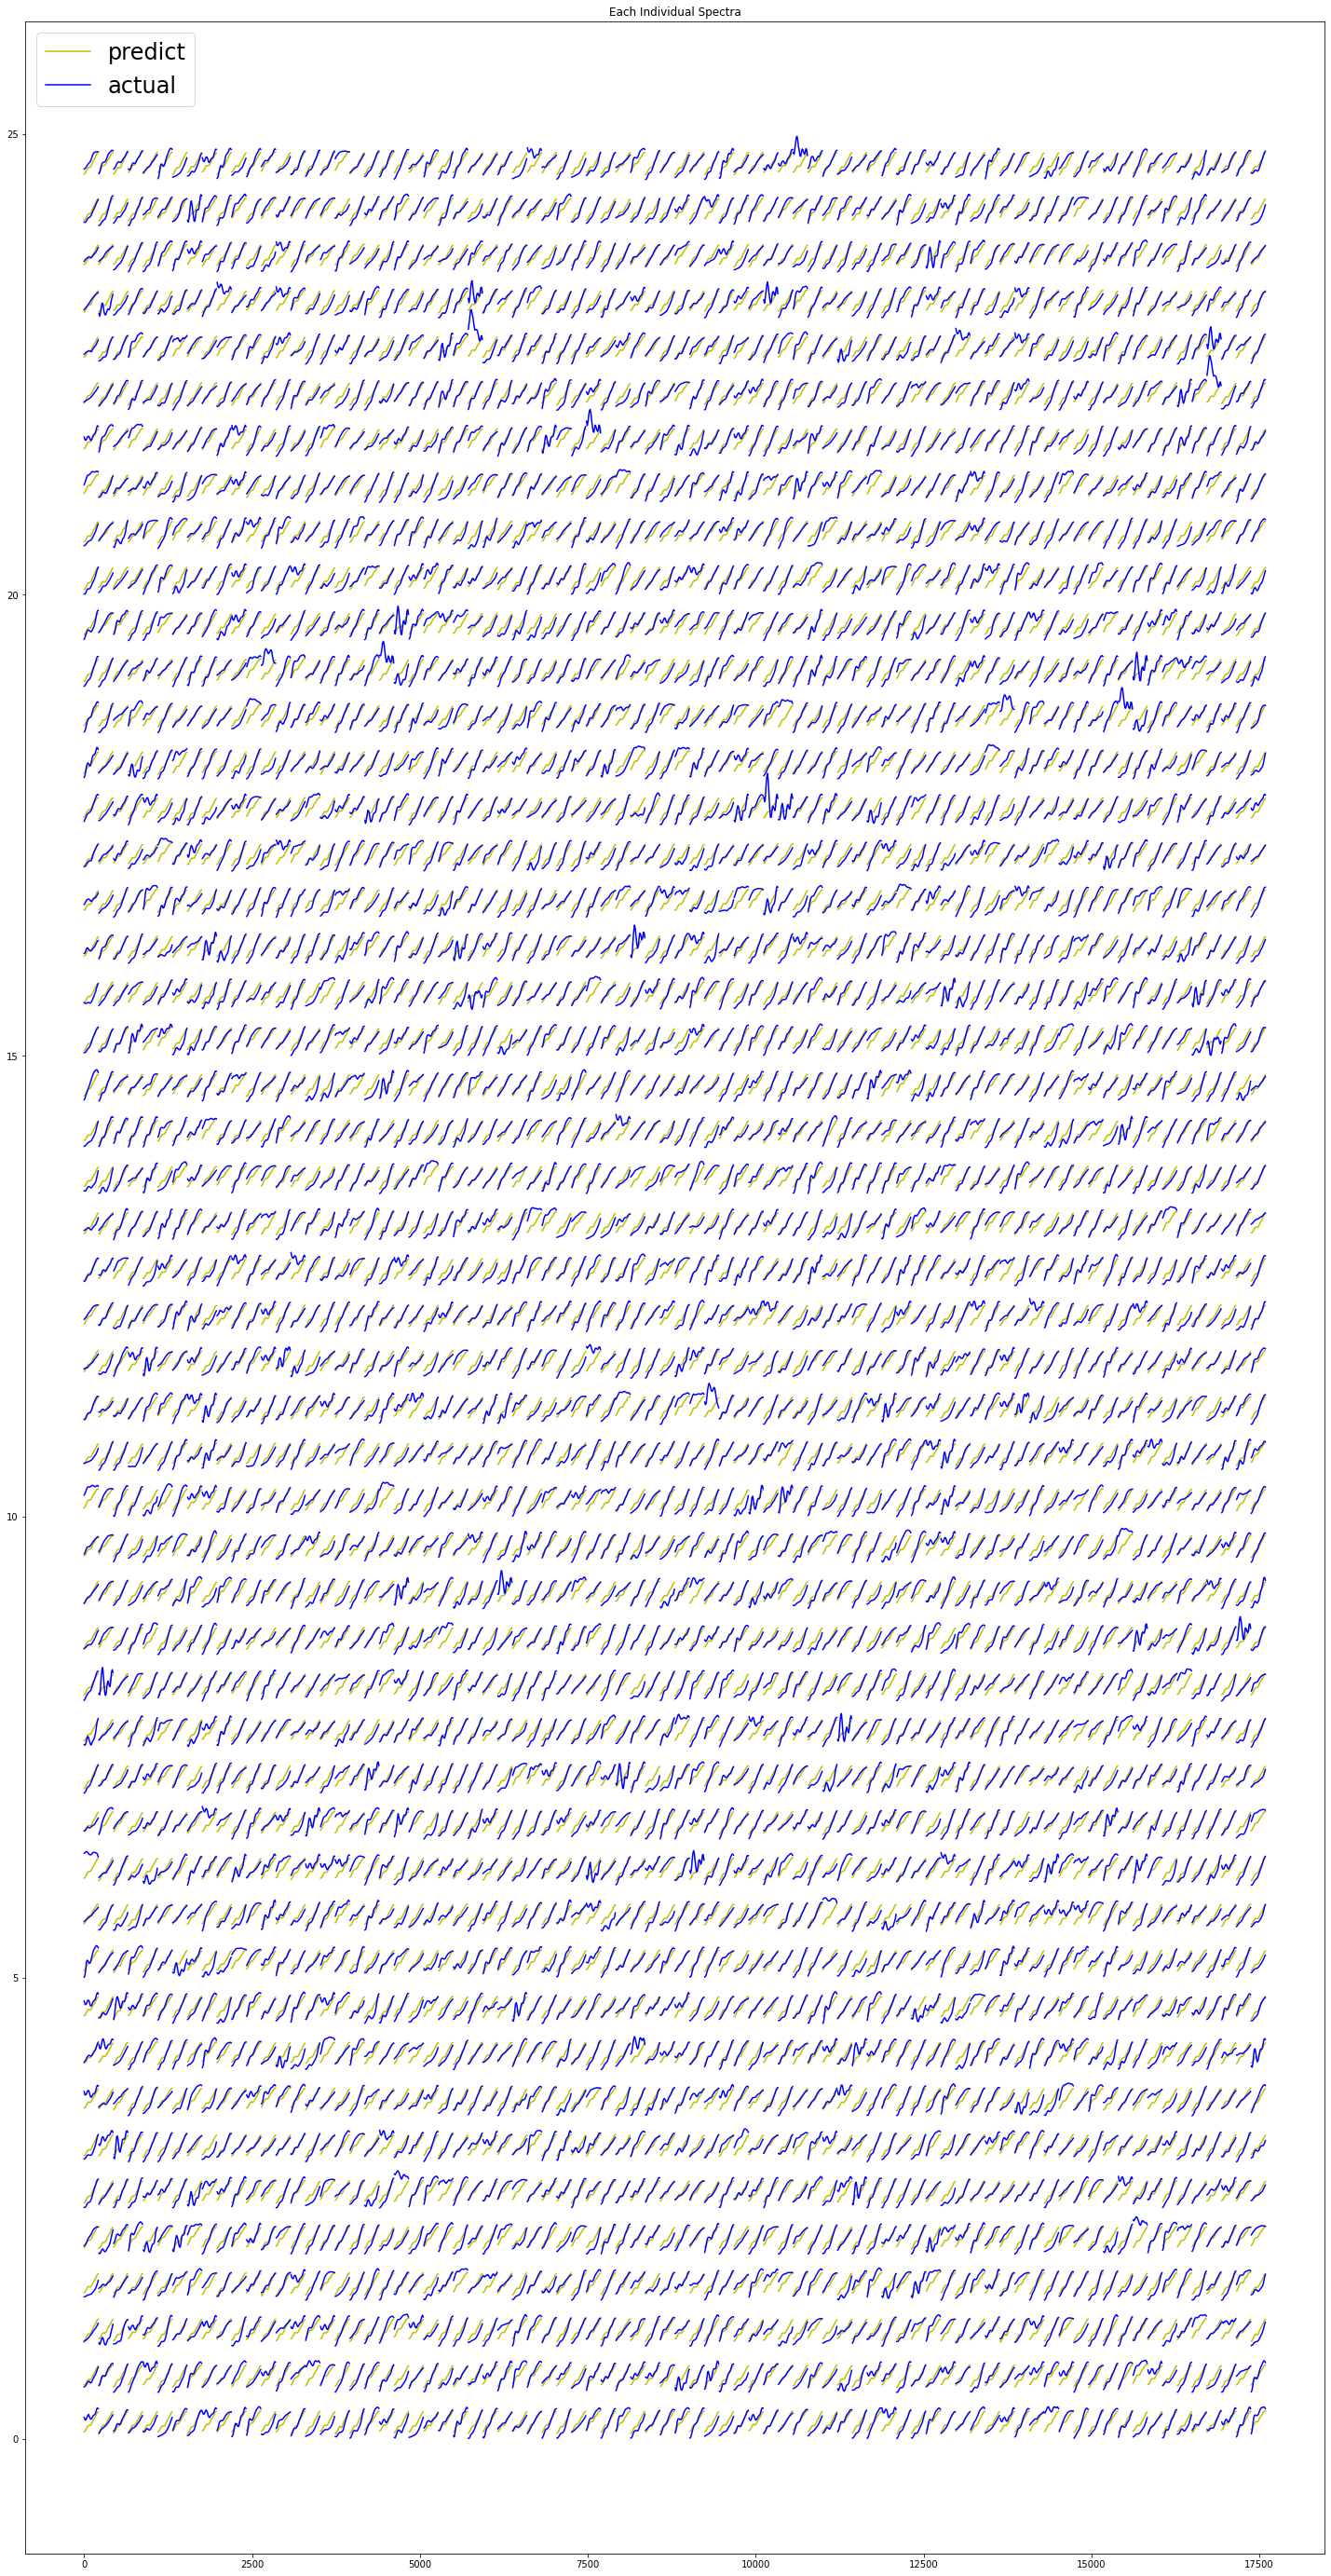

In [ ]:
# DO NOT RUN UNLESS NEEDED - not visually easy on the eyes and 100 random is better
# Creates Grid of All Spectras in Testing set

def closest_factor(num):
  n = int(np.sqrt(num))
  if num % n == 0:
    return n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_test)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]
fig = plt.figure(figsize=(25, 50))
low, high = closest_factor(len(x_test))
for j in range(low):
  for i in range(high):
    plt.plot(x + 220*i, y[50*j+i]+.5*j, color = 'b')
    plt.plot(x + 220*i, y_test[50*j+i]+.5*j, color = 'y')
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Each Individual Spectra', fontsize = 20)
plt.savefig('EverySpectra.jpg')
plt.show()

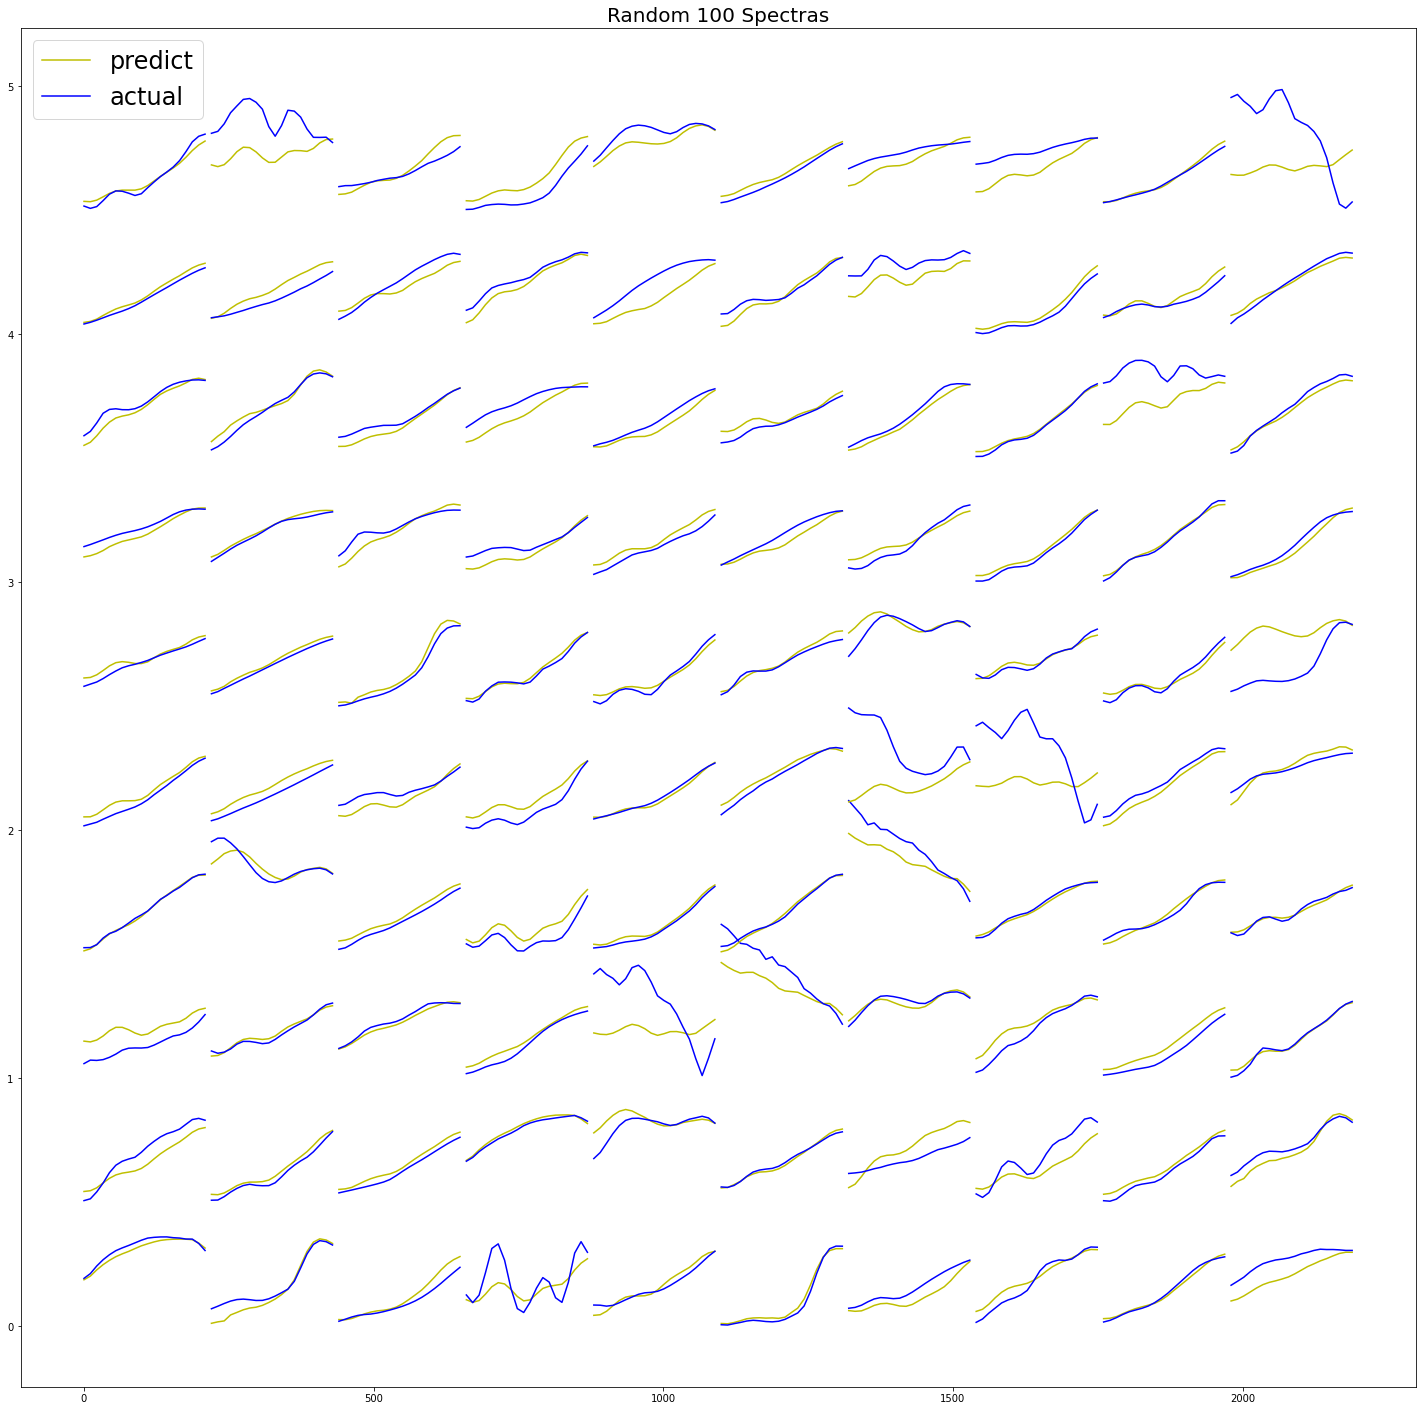

In [ ]:
# Creates Random 100 Grid of Spectras from Validation Data

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
rando = [x for x in range(len(y))]
random.shuffle(rando)
fig = plt.figure(figsize=(25, 25))
for j in range(10):
  for i in range(10):
    rand = rando[10*j + i]
    plt.plot(x + 220*i, y[rand]+.5*j, color = 'b')
    plt.plot(x + 220*i, y_valid[rand]+.5*j, color = 'y')
    i+=1
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Random 100 Absorption Spectras', fontsize = 20)
plt.savefig('Random100Grid.jpg')
plt.show()

In [ ]:
#Histogram
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
y_valid = np.array(y_valid)
fig = plt.figure(figsize=(10, 5))
#n, bins, patches = plt.hist((y_pred-y_valid)/y_valid, bins=100)
y=100*(y_pred-y_valid)/y_valid
y = np.array(y).flatten()
plt.hist(y, bins=500)
#for spectra in y:
#  plt.plot(y, 'o')
#plt.show()
#plt.xlabel('Percent Error', fontsize=12)
#plt.ylabel('', fontsize=12)
#plt.title('Percent Error', fontsize=20)


NameError: ignored

ValueError: ignored

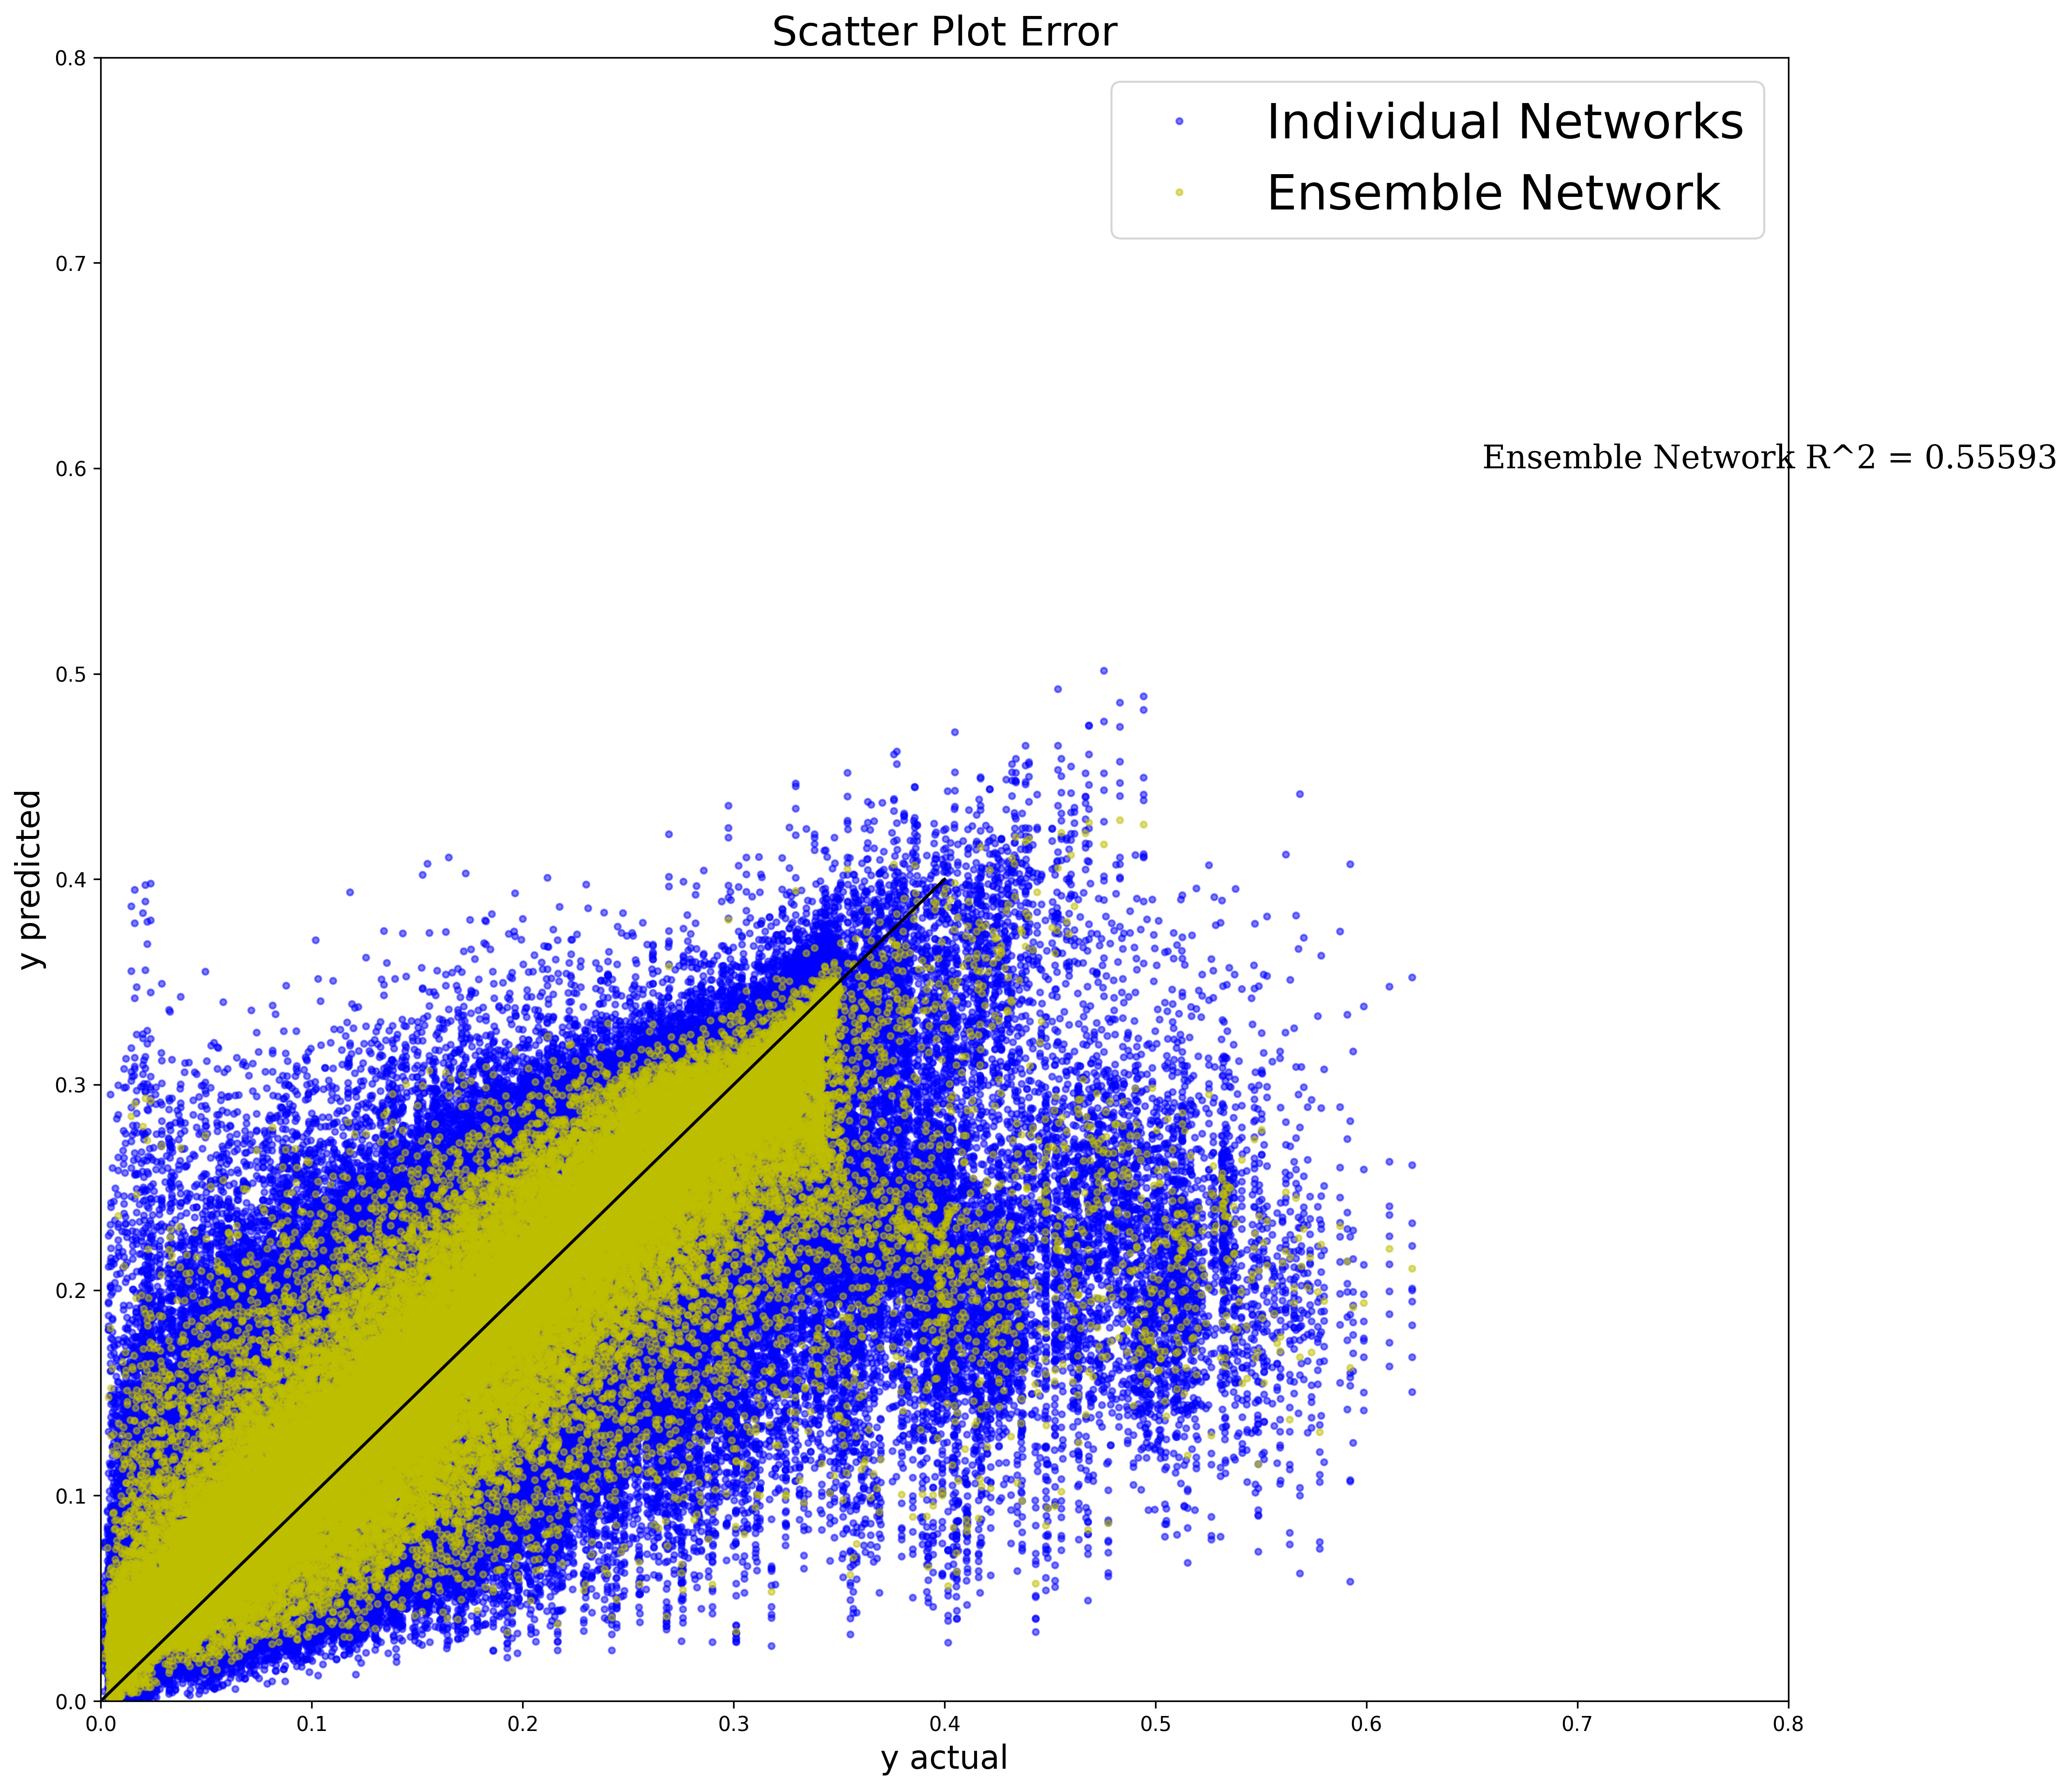

In [ ]:
# Make Scatterplot Error graph with GEOMETRIC MEAN, blue is all networks, yellow is average

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(15, 15), dpi=300)
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.5, color = 'b', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.5, color = 'y', label = 'Ensemble Network')
a, b = 0, .4 
plt.axis([0, .8, 0, .8])
plt.plot([a,b],[a,b], color='black')
plt.title('Scatter Plot Error', fontsize = 20)
plt.xlabel('y actual', fontsize = 16)
plt.ylabel('y predicted', fontsize = 16)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
axe.text(.65, 0.6, f" Ensemble Network R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
axe.text(.65, 0.55, f"Individual Networks R^2 = {round(r2_score(np.array(predictList), np.array(y_valid*5).flatten()))}", fontdict = font)
plt.savefig('SymErrorGeo.jpg')
plt.show()

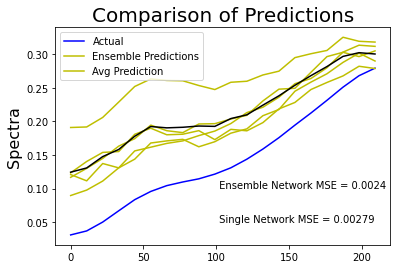

In [ ]:
# Create comparison graph of the actual spectra (blue), each networks predicted spectra (yellow), and the final averaged prediction (black)

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
fig, axe = plt.subplots()
plt.plot(x, y_valid[0], color = 'b')
for predict in predictList:
  plt.plot(x, predict[0], color = 'y')
plt.plot(x,y_pred[0], color = 'black')
plt.legend(['Actual', 'Ensemble Predictions', 'Avg Prediction'], loc = 'upper left')
plt.title('Comparison of Predictions', fontsize = 20)
plt.ylabel('Spectra', fontsize = 16)
plt.savefig('PredictCompare.jpg')
axe.text(100, 0.1, f" Ensemble Network MSE = {round(float(np.mean((y_pred - y_valid)**2)), 5)}")
axe.text(100, 0.05, f" Single Network MSE = {round(float(np.mean((predictList[0] - y_valid)**2)), 5)}")
plt.show()


Accuracy = 0.076375
Total MSE = 0.011410720646381378


[Text(0, 0.5, 'y_predicted'), Text(0.5, 0, 'y_actual')]

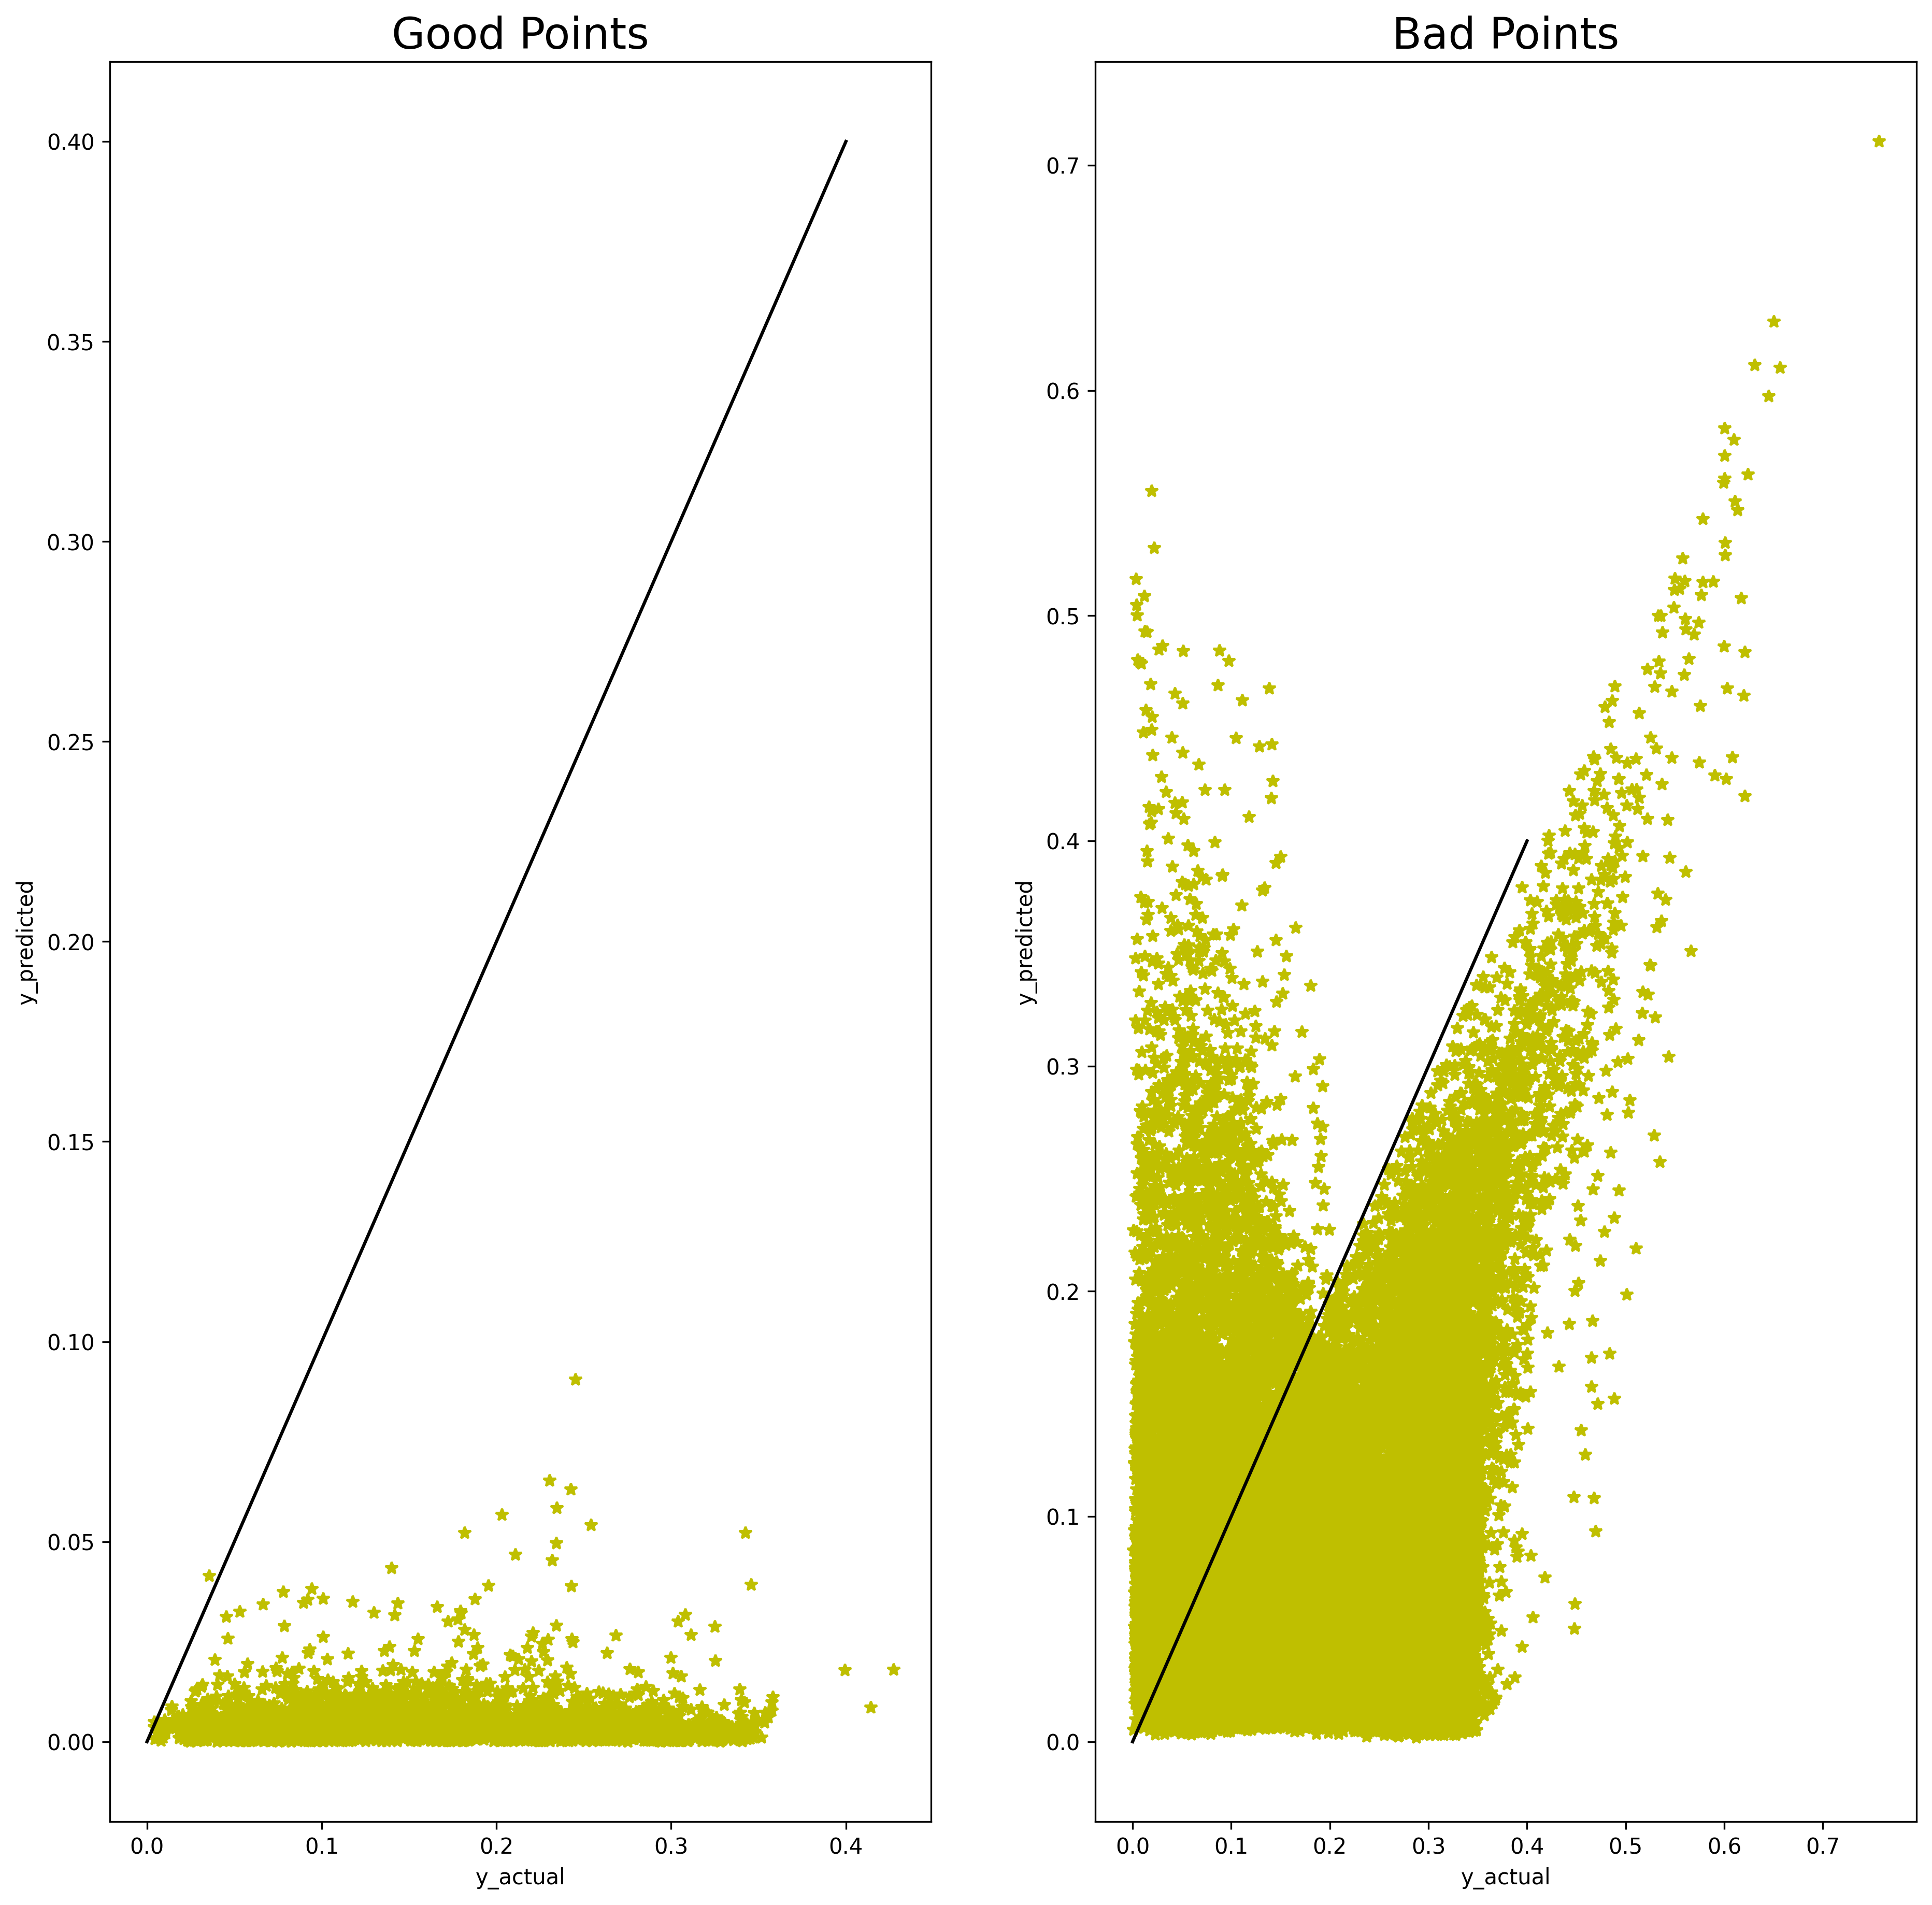

In [ ]:
# accuracy thingy majig

y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
UQ = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])
goodX, goodY = [], []
badX, badY = [], []
for i, spectra in enumerate(np.abs(y_pred - y_valid)):
  for j, ele in enumerate(spectra):
    if ele < UQ[i][j]*1.96/np.sqrt(numNetworks):
      goodY.append(y_pred[i][j])
      goodX.append(y_valid[i][j])
    else:
      badY.append(y_pred[i][j])
      badX.append(y_valid[i][j])
print(f'Accuracy = {len(goodX)/(20*len(x_valid))}')
print(f'Total MSE = {np.mean((y_valid-y_pred)**2)}')
fig, ax = plt.subplots(1, 2, figsize=(15, 15), dpi=300)
ax[0].plot(goodX, goodY, '*', color = 'y')
a, b = 0, .4 
ax[0].plot([a,b],[a,b], color='black')
ax[0].set_title('Good Points', fontsize = 20)
ax[0].set(xlabel='y_actual', ylabel='y_predicted')

ax[1].plot(badX, badY, '*', color = 'y')
a, b = 0, .4 
ax[1].plot([a,b],[a,b], color='black')
ax[1].set_title('Bad Points', fontsize = 20)
ax[1].set(xlabel='y_actual', ylabel='y_predicted')



In [ ]:
print(np.shape(goodX))
print(np.shape(badX))

(8863,)
(31137,)


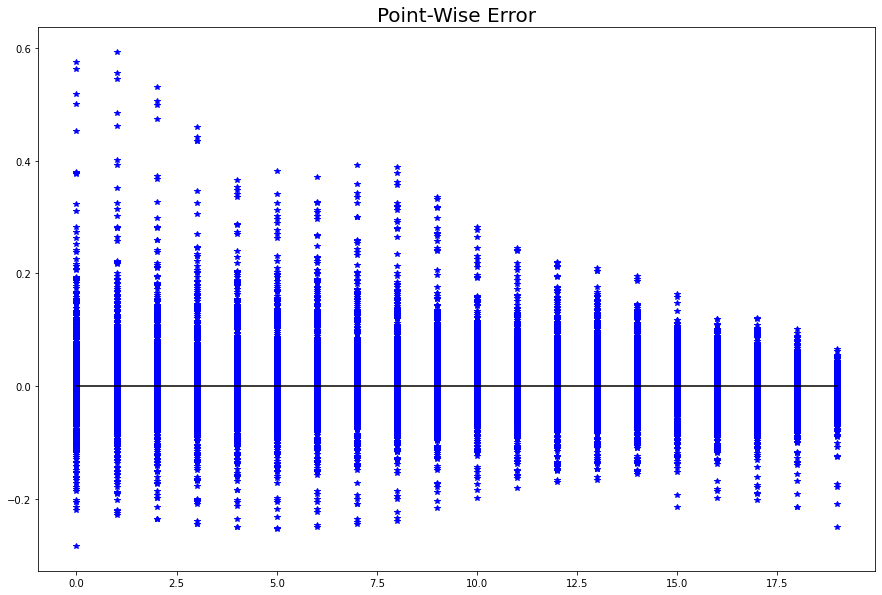

In [ ]:
# Run if you are splicing, if not spliced might be really hard to view
# Second Error graph - shows error for each point

predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))]
fig = plt.figure(figsize=(15, 10))
for i in range(len(x_valid)):
  plt.plot(y_valid[i] - y_pred[i], '*', color = 'b')
plt.plot([0, numOutputs - 1],[0,0], color = 'black')
plt.title('Point-Wise Error', fontsize = 20)
plt.savefig('PointWiseError.jpg')
plt.show()

In [ ]:
# DO NOT RUN UNLESS NEEDED - arithmetic not geometric graph
# Make Scatterplot Error graph with ARITHMETIC MEAN, blue is all networks, yellow is average

from sklearn.metrics import r2_score
predictList = makePredictionsList(modelList, x_valid)
y_pred = [ensemblePredictArithAverage(predictList, ele) for ele in range(len(x_valid))]
fig, axe = plt.subplots(figsize=(10, 10), dpi=300)
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  for model in range(numNetworks):
    plt.plot(x, np.transpose(predictList[model])[i], '.', alpha=0.5, color = 'b', label = 'Individual Networks')
for i in range(numOutputs):
  x = np.transpose(y_valid)[i]
  plt.plot(x, np.transpose(y_pred)[i], '.', alpha=0.5, color = 'y', label = 'Ensemble Network')
a, b = 0, .4 
plt.plot([a,b],[a,b], color='black')
plt.title('Symmetric Error Graph', fontsize = 20)
plt.xlabel('y actual', fontsize = 16)
plt.ylabel('y predicted', fontsize = 16)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 24})
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
axe.text(.425, 0.4, f"R^2 = {round(r2_score(np.array(y_pred).flatten(), np.array(y_valid).flatten()), 5)}", fontdict = font)
plt.savefig('SymErrorArith.jpg')
plt.show()

NameError: ignored

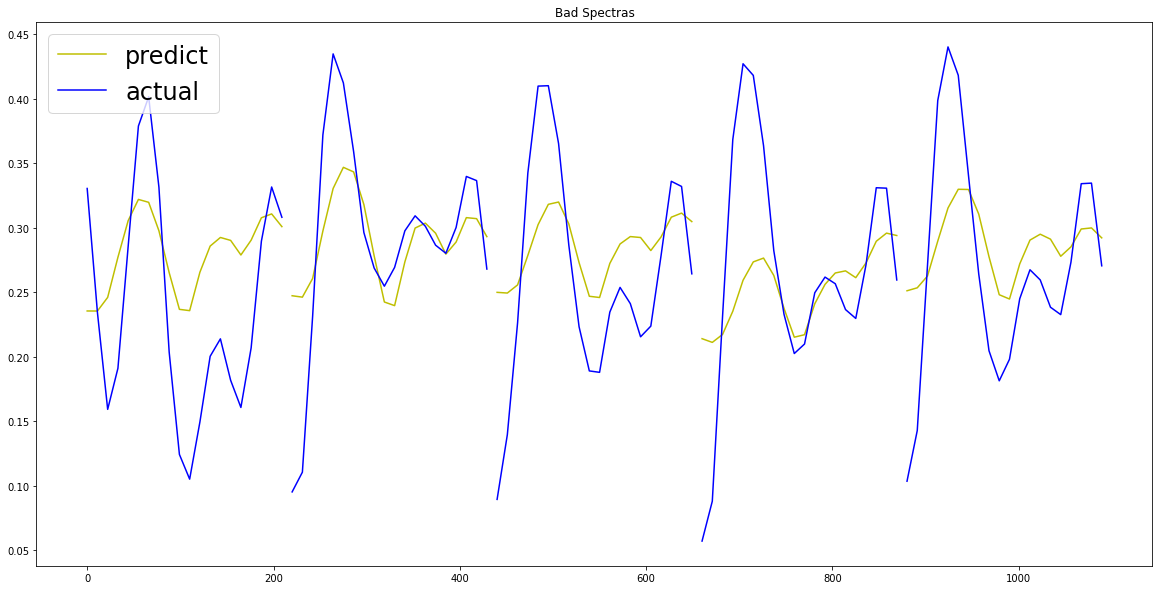

[[b'In.PM.AtFr', 23, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
[[b'Lu.PM.AtFr', 31, 1.0]]
----
[[b'In.PM.AtFr', 23, 1.0]]: 1
[[b'Lu.PM.AtFr', 31, 1.0]]: 4


In [ ]:
# DO NOT RUN UNLESS NEEDED - not really relevant anymore
# Puts out all very wavy spectra graphs and their associated information

bad = []
y = []
indexList = []
for i, ele in enumerate(y_valid):
  if max(ele) >= .4:
    bad.append(y_pred[i])
    y.append(ele)
    indexList.append(i)

x = np.array([x for x in range(0,220,splicingVal)])
fig = plt.figure(figsize=(20, 10))
#low, high = closest_factor(len(bad))

for j in range(10):
  for i in range(10):
    try:
      plt.plot(x + 220*i, bad[i+10*j]+.5*j, color = 'y')
      plt.plot(x + 220*i, y[i+10*j]+.5*j, color = 'b')
    except: 
      break
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.title('Bad Spectras', fontsize = 20)
plt.savefig('Bad.jpg')
plt.show()

def nonZeroInList(arr):
  returnList = []
  for i, ele in enumerate(arr):
    if ele > 0.0:
      returnList.append([hf['atfrac_keys'][i], i, ele])
  return returnList
  
def frequencyOfItems(arr):
  frequency = {}
  for item in arr:
    if str(item) in frequency:
        frequency[str(item)] += 1
    else:
        frequency[str(item)] = 1
  return frequency
iter = 0
oxideList = []
for index in indexList:
  metal = np.transpose(hf['atfrac'])[subsetSize + index][0:42]
  #print(iter, nonZeroInList(metal))
  oxideList.append(nonZeroInList(metal))
  iter += 1
sort = sorted(oxideList, key = lambda oxide: (oxide[0][1], len(oxide), oxide[0][2]))
for each in sort:
  print(each)
print('----')
for key, value in frequencyOfItems(sort).items():
  print(f'{key}: {value}')


In [ ]:
# Saving Code Block: uploads models under names to google drive, must move these to the Shared Drive

names = ['EpochOutput.txt', 'First10.jpg', 'Random10.jpg', 'ModelAccuracyMSLE.jpg', 'ModelAccuracyMAPE.jpg', 'PredictCompare.jpg', 'Bad.jpg', 'EverySpectra.jpg', 'SymErrorGeo.jpg', 'SymErrorArith.jpg', 'PointWiseError.jpg', 'MSE_Plot.jpg', 'Random100Grid.jpg', 'AllPredictions.jpg']
for name in names:
  try:
    colab_link = name
    gdrive_link = "/content/drive/My Drive/Colab Notebooks/Models"
    shutil.copy(colab_link, gdrive_link)
  except:
    print(f'{name} not downloaded')

ModelAccuracyMSLE.jpg not downloaded
ModelAccuracyMAPE.jpg not downloaded
PredictCompare.jpg not downloaded
Bad.jpg not downloaded
EverySpectra.jpg not downloaded
SymErrorArith.jpg not downloaded
AllPredictions.jpg not downloaded


In [ ]:
# DO NOT RUN
# Just shows various error functions to use

y0 = y_test
predictList = makePredictionsList(modelList, x_test)
y1 = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]

dy = y0-y1 # error 
abs_dy = np.abs(y0-y1)    # absolute error 
relerr = np.abs(y0-y1)/y0   # relative error 
pererr = np.abs(y0-y1)/y0*100    # percentage error 
mean_err = np.mean(np.abs(y0-y1))     # mean absolute error 
MSE = np.mean((y0-y1)**2)        # Mean square error 
RMSE = np.sqrt(np.mean((y0-y1)**2))  # Root mean square error

In [ ]:
# DO NOT RUN
# Plots First 10 predictions all on the same graph
# Only use if you need to investigate oscillations in spectra graphs

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x, y[i] , color = 'y')    
  plt.legend(['predict'], loc='upper left')  
  plt.title('Combined First 10 Predictions', fontsize = 20)
plt.savefig('AllPredictions.jpg')
plt.show()

In [ ]:
# DO NOT RUN
# Attempt to implement Custom Loss Function, still a work in progress

def custom_loss(y_true, y_pred):
  #shape of y_true/y_pred = (batchSize, numOutputs)
  #distance metric
  lossDistance = tf.square(y_pred - y_true)
  return lossDistance
  #smoothness metric
  Deriv2 = 0
  for batch in range(batchSize):
    for i in range(numOutputs):
      if i == numOutputs - 3:
        break
      Deriv2 += 1

def SMU(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU_mu', shape=(),
                       initializer=tf.constant_initializer(1000000),
                       dtype=tf.float32)
    return ((1+alpha)*x + (1-alpha)*x*tf.math.erf(mu*(1-alpha)*x))/2

def SMU1(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU1_mu', shape=(),
                       initializer=tf.constant_initializer(4.352665993287951e-9),
                       dtype=tf.float32)
    return ((1+alpha)*x+tf.math.sqrt(tf.math.square(x-alpha*x)+tf.math.square(mu)))/2

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

#get_custom_objects().update({'SMU': Activation(SMU)}) 
#get_custom_objects().update({'SMU1': Activation(SMU1)}) 

In [ ]:
# DO NOT RUN 
# Use this only if we want to load an already built model
normal_model = load_model('Model.h5')

OSError: ignored

In [ ]:
# DO NOT RUN
# Attempted neural network for the outcomes of the ensemble, returned bad graphs so scratched for now, may implement later

def get_model_from_ensemble():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (numNetworks, numOutputs)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=20, activation='softsign')
    ])
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = [metrics.mean_squared_logarithmic_error, metrics.mean_absolute_percentage_error]))
    return model

# fixed input parameters
modelInput = makePredictionsList(modelList, x_train)
modelInput = np.transpose(modelInput, (1, 0, 2))

sys.stdout = open('EpochOutput2.txt', 'w') 
epochs = 50
batch_size = 64
x_train2, x_test2, y_train2, y_test2 = train_test_split(modelInput, spectra, test_size = 0.2, random_state = None)
final_model = get_model_from_ensemble()
final_history = final_model.fit(x_train2, y_train2, batch_size = batch_size,
              epochs = epochs, validation_data = (x_test2, y_test2), verbose = 1)
sys.stdout = terminal

# Plots to visualize the mean squared logarithmic error and mean absolute percentage error of our final neural network ensemble model

# MSLE
plt.plot(final_history.history['mean_squared_logarithmic_error'], label='MSLE training data')
plt.plot(final_history.history['val_mean_squared_logarithmic_error'], label='MSLE validation data')
plt.legend()
plt.title('Mean Squared Logarithmic Error Over Time')
plt.ylabel('MSLE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMSLE.jpg')
plt.show()

# MAPE
plt.plot(final_history.history['mean_absolute_percentage_error'], label='MAPE training data')
plt.plot(final_history.history['val_mean_absolute_percentage_error'], label='MAPE validation data')
plt.legend()
plt.title('Mean Absolute Percentage Error Over Time')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMAPE.jpg')
plt.show()